# Generative Adversarial Network

In [276]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from keras import Model
from keras.layers import Flatten, Reshape, Input, Activation, Conv2D, Conv2DTranspose, UpSampling2D, Dropout, Dense, BatchNormalization
from keras.optimizers import RMSprop

### Load Preprocessed Quick Draw Images

In [8]:
input_images = "resources/full_numpy_bitmap_squirrel.npy"
data = np.load(input_images)

In [9]:
data.shape, data[0].shape

((156883, 784), (784,))

### Perform Additional Preprocessing

In [10]:
data = data / 255
data = np.reshape(data, (data.shape[0], 28, 28, 1))
img_w, img_h = data.shape[1:3]

In [11]:
data.shape

(156883, 28, 28, 1)

### Preview a Training Example

In [17]:
data[0].shape

(28, 28, 1)

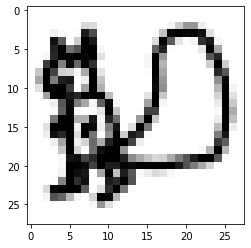

In [100]:
plt.imshow(data[1].reshape(28,28), cmap="Greys")
plt.show()
# Alternatively:
# plt.imshow(data[0,:,:,0], cmap="Greys")

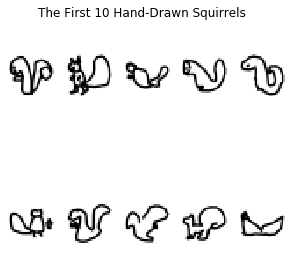

In [137]:
n_preview = 10
fig, ax = plt.subplots(figsize=(5,5))
output_images = []

for i in range(n_preview):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i,:,:,0], cmap="Greys")
    plt.axis("off")
    output_images.append(data[i,:,:,0])

plt.suptitle("The First 10 Hand-Drawn Squirrels", y=0.9)
plt.show()

In [144]:
len(flattened_images)

280

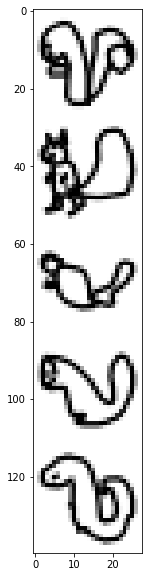

In [152]:
# Create one image from 10 images - column
flattened_images = np.array([r for i in output_images[0:5] for r in i])
plt.figure(figsize=(10,10))
plt.imshow(flattened_images, cmap="Greys")
plt.show()

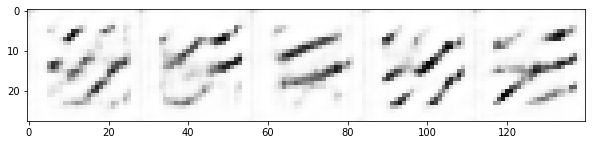

In [280]:
# Create one image from 10 images - row
f = np.array([])
for im in output_images[0:5]:
    if len(f) == 0:
        f = np.array([r for r in im])
    else:
        f = np.concatenate([f, np.array([r for r in im])], axis=1)

plt.figure(figsize=(10,10))
plt.imshow(f, cmap="Greys")
plt.show()

In [281]:
type(f)

numpy.ndarray

### Build the Discriminator

In [204]:
def build_discriminator(depth=64, dropout=0.4):
    
    # Input definition
    img_input = Input(shape=(img_w, img_h, 1))
    
    conv_1 = Conv2D(depth*1, 5, strides=2, activation="relu", padding="same", name="conv_1")(img_input)
    conv_1 = Dropout(dropout, name="dropout_conv_1")(conv_1)
    
    conv_2 = Conv2D(depth*2, 5, strides=2, activation="relu", padding="same", name="conv_2")(conv_1)
    conv_2 = Dropout(dropout, name="dropout_conv_2")(conv_2)
    
    conv_3 = Conv2D(depth*3, 5, strides=2, activation="relu", padding="same", name="conv_3")(conv_2)
    conv_3 = Dropout(dropout, name="dropout_conv_3")(conv_3)    
    
    conv_4 = Conv2D(depth*4, 5, strides=1, activation="relu", padding="same", name="conv_4")(conv_3)
    conv_4 = Flatten()(Dropout(dropout, name="dropout_conv_4")(conv_4))
    
    # Output layer
    prediction = Dense(1, activation="sigmoid", name="output")(conv_4)
    
    # Assemble model
    model = Model(inputs=img_input, outputs=prediction)
    
    return model
    

In [205]:
z_dimensions = 32

In [206]:
def build_generator(latent_dim=z_dimensions, depth=64, dropout=0.4):
    
    # Input definition
    noise = Input(shape=(latent_dim,))
    
    # Dense layer - this enables the latent space input to be mapped to subsequent de-convolutional layers
    dense_1 = Dense(7*7*depth)(noise)
    dense_1 = BatchNormalization(momentum=0.9)(dense_1)
    dense_1 = Activation(activation="relu")(dense_1)
    dense_1 = Reshape((7,7,depth))(dense_1)
    dense_1 = Dropout(dropout)(dense_1)
    
    # De-convolutional layers
    de_conv_1 = UpSampling2D()(dense_1)
    de_conv_1 = Conv2DTranspose(int(depth/2), 5, padding="same", activation=None,)(de_conv_1)
    de_conv_1 = BatchNormalization(momentum=0.9)(de_conv_1)
    de_conv_1 = Activation(activation="relu")(de_conv_1)
    
    de_conv_2 = UpSampling2D()(de_conv_1)
    de_conv_2 = Conv2DTranspose(int(depth/4), 5, padding="same", activation=None,)(de_conv_2)
    de_conv_2 = BatchNormalization(momentum=0.9)(de_conv_2)
    de_conv_2 = Activation(activation="relu")(de_conv_2)
    
    de_conv_3 = Conv2DTranspose(int(depth/8), 5, padding="same", activation=None,)(de_conv_2)
    de_conv_3 = BatchNormalization(momentum=0.9)(de_conv_3)
    de_conv_3 = Activation(activation="relu")(de_conv_3)
    
    # Output image
    image = Conv2D(1, 5, padding="same", activation="sigmoid")(de_conv_3)
    
    # Assemble model
    model = Model(inputs=noise, outputs=image)
    
    return model

In [207]:
discriminator = build_discriminator()

discriminator.compile(loss="binary_crossentropy",
                      optimizer=RMSprop(learning_rate=0.0008, decay=6e-8, clipvalue=1.0),
                      metrics=["accuracy"])

In [208]:
generator = build_generator()

In [209]:
generator.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization_14 (Batc (None, 3136)              12544     
_________________________________________________________________
activation_13 (Activation)   (None, 3136)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 14, 14, 64)        0  

In [210]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

adversarial_model.compile(loss="binary_crossentropy",
                      optimizer=RMSprop(learning_rate=0.0004, decay=3e-8, clipvalue=1.0),
                      metrics=["accuracy"])

In [244]:
epochs = 20
def train(epochs=epochs, batch=128, z_dim=z_dimensions):
    # Set up loss and accuracy variables
    
    discriminator_metrics = []
    adversarial_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    generative_image_history = np.array([])
    
    # For each epoch:
    for i in range(epochs):
        # Sample real images
        real_images = np.reshape(
            data[np.random.choice(data.shape[0], batch, replace=False)], (batch, 28, 28, 1)
        )
        
        # Generate fake images
        fake_images = generator.predict(
            np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        )
        
        # Concatenate images
        x = np.concatenate((real_images, fake_images))
        
        # Concatenate labels for batch
        y = np.ones([2*batch, 1])
        y[batch:, :] = 0
        
        # Train discriminator
        discriminator_metrics.append (
            discriminator.train_on_batch(x, y)
        )
        
        # Update running metrics
        running_d_loss += discriminator_metrics[-1][0]
        running_d_acc += discriminator_metrics[-1][1]
        
        # Generate noise to pass into generator
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        
        # Generate "true" labels
        y = np.ones([batch, 1])
        
        # Train adversarial network
        adversarial_metrics.append(
            adversarial_model.train_on_batch(noise, y)
        )
        
        # Update running metrics
        running_a_loss += adversarial_metrics[-1][0]
        running_a_acc += adversarial_metrics[-1][1]        
        
        # Print progress
        if (i+1)%10 == 0:
            print("Epoch #{}:".format(i+1))
            print("-> Discriminator -> Loss: {:.2f} | Accuracy: {:.2f}".format(running_d_loss/i, running_d_acc/i))
            print("-> Adversarial Net -> Loss: {:.2f} | Accuracy: {:.2f}".format(running_a_loss/i, running_a_acc/i))
            
            # Generate fake images
            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            generative_images = generator.predict(noise)
            
            if len(generative_image_history) == 0:
                generative_image_history = generative_images
            else:
                generative_image_history = np.concatenate([generative_image_history, generative_images])
            
            # Plot
            plt.figure(figsize=(5,5))
            for j in range(generative_images.shape[0]):
                plt.subplot(4, 4, j+1)
                plt.imshow(generative_images[j,:,:,0], cmap="Greys")
                plt.axis("off")
                
            plt.tight_layout()
            plt.show()
        
    return adversarial_metrics, discriminator_metrics, generative_image_history

Epoch #10:
-> Discriminator -> Loss: 0.40 | Accuracy: 0.97
-> Adversarial Net -> Loss: 2.61 | Accuracy: 0.12


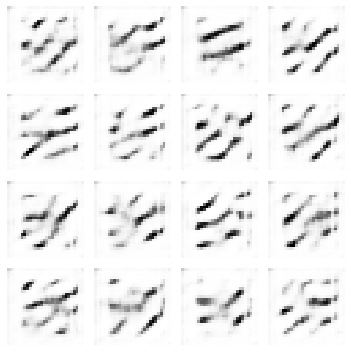

Epoch #20:
-> Discriminator -> Loss: 0.41 | Accuracy: 0.93
-> Adversarial Net -> Loss: 2.69 | Accuracy: 0.11


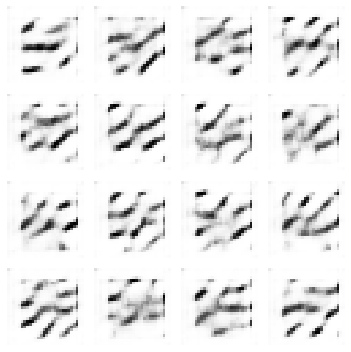

In [245]:
adversarial_metrics, discriminator_metrics, generative_image_history = train()

In [265]:
output_images = []

for i in range(len(generative_image_history)):
    output_images.append(generative_image_history[i,:,:,0])

In [268]:
# f = np.array([])
# for im in output_images[0:16]:
#     if len(f) == 0:
#         f = np.array([r for r in im])
#     else:
#         f = np.concatenate([f, np.array([r for r in im])], axis=1)

# plt.figure(figsize=(10,10))
# plt.imshow(f, cmap="Greys")
# plt.axis("off")
# plt.show()

In [278]:
#fig = plt.figure(dpi=100, figsize=plt.figaspect(image_history))
fig = plt.figure(dpi=100)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis("off")
ims = []

for i in range(int(epochs/10)):
    f = np.array([])
    for im in output_images[i*16:(i+1)*16]:
        if len(f) == 0:
            f = np.array([r for r in im])
        else:
            f = np.concatenate([f, np.array([r for r in im])], axis=1)
    ims.append((plt.imshow(f, cmap="Greys"),))

training_animation = animation.ArtistAnimation(fig, ims, blit=True, interval=100, repeat=False)

training_animation.save(("test.gif"), writer="imagemagick")
plt.close()

28
28


In [279]:
0 % 4

0

In [ ]:
#fig = plt.figure(dpi=100, figsize=plt.figaspect(image_history))
fig = plt.figure(dpi=100)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis("off")
ims = []

for i in range(int(epochs/10)):
    frame = np.array([])
    row = np.array([])
    for idx, im in enumerate(output_images[i*16:(i+1)*16]):
      if len(row) == 0:
        row = np.array(im)
      else:
        row = np.concatenate([row, np.array(im)], axis=1)
      if idx == 3:
          frame = row
          row = np.array([]) 
      elif idx == 7 or idx == 11 or idx == 15:
          frame = np.concatenate([frame, row])
          row = np.array([])

    ims.append((plt.imshow(frame, cmap="Greys"),))

training_animation = animation.ArtistAnimation(fig, ims, blit=True, interval=100, repeat=False)

training_animation.save(("../resources/test.gif"), writer="imagemagick")
plt.close()